<a href="https://colab.research.google.com/github/SeungHan0816/WM-811k_Wafermap_Practice/blob/main/WM_811k_Wafermap_DL_MO_S4_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MobileOne-S4 딥러닝 알고리즘 사용

# 1단계. 라이브러리 및 환경 설정

!pip install kagglehub timm --quiet

import os
import warnings
import kagglehub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.transform import resize
import timm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
✅ Using device: cuda


In [ ]:
# 2단계. 데이터 로딩 및 전처리

path = kagglehub.dataset_download('qingyi/wm811k-wafer-map')
df = pd.read_pickle(os.path.join(path, "LSWMD.pkl"))

def safe_extract_failure_type(x):
    while isinstance(x, (list, np.ndarray)):
        if isinstance(x, np.ndarray) and x.shape == ():
            x = x.item(); continue
        if len(x) == 0:
            return 'none'
        x = x[0]
    return x if isinstance(x, str) else str(x)

df['failureType'] = df['failureType'].apply(safe_extract_failure_type)
failure_map = {
    'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3,
    'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7,
    'none':8
}
df['label'] = df['failureType'].map(failure_map)
df = df[df['label'] != 8].reset_index(drop=True)
df.drop(columns=['waferIndex', 'lotName', 'trianTestLabel'], errors='ignore', inplace=True)
print("✅ 데이터 전처리 완료")


✅ 데이터 전처리 완료


In [ ]:
# 3단계. Custom Dataset 정의

class WaferDataset(Dataset):
    def __init__(self, df):
        self.maps = df['waferMap'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.maps[idx].astype(np.float32)
        img = resize(img, (128, 128), order=0, preserve_range=True).astype(np.float32)
        img = np.repeat(img[None], 3, axis=0) / 2.0
        return torch.tensor(img), torch.tensor(self.labels[idx], dtype=torch.long)


In [ ]:
# 4단계. 데이터 분할 및 클래스 통계 + 샘플링

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

def print_stats(df, name):
    print(f"\n{name} 데이터 수: {len(df)}개")
    for l, c in df['label'].value_counts().sort_index().items():
        print(f"  클래스 {l}: {c}개 ({c/len(df)*100:.2f}%)")

print(f"🔹 전체 샘플 수: {len(df)}개")
print_stats(df, "전체")
print_stats(train_df, "🟢 학습")
print_stats(test_df, "🔵 테스트")

label_counts = np.bincount(train_df['label'])
class_weights = 1.0 / label_counts
sample_weights = class_weights[train_df['label'].values]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(WaferDataset(train_df), batch_size=16, sampler=sampler)
test_loader = DataLoader(WaferDataset(test_df), batch_size=16, shuffle=False)

print("✅ DataLoader 구성 완료")


🔹 전체 샘플 수: 25519개

전체 데이터 수: 25519개
  클래스 0: 4294개 (16.83%)
  클래스 1: 555개 (2.17%)
  클래스 2: 5189개 (20.33%)
  클래스 3: 9680개 (37.93%)
  클래스 4: 3593개 (14.08%)
  클래스 5: 866개 (3.39%)
  클래스 6: 1193개 (4.67%)
  클래스 7: 149개 (0.58%)

🟢 학습 데이터 수: 20415개
  클래스 0: 3435개 (16.83%)
  클래스 1: 444개 (2.17%)
  클래스 2: 4151개 (20.33%)
  클래스 3: 7744개 (37.93%)
  클래스 4: 2874개 (14.08%)
  클래스 5: 693개 (3.39%)
  클래스 6: 955개 (4.68%)
  클래스 7: 119개 (0.58%)

🔵 테스트 데이터 수: 5104개
  클래스 0: 859개 (16.83%)
  클래스 1: 111개 (2.17%)
  클래스 2: 1038개 (20.34%)
  클래스 3: 1936개 (37.93%)
  클래스 4: 719개 (14.09%)
  클래스 5: 173개 (3.39%)
  클래스 6: 238개 (4.66%)
  클래스 7: 30개 (0.59%)
✅ DataLoader 구성 완료


In [ ]:
# 5단계. MobileOne-S4 모델 정의 (Dropout 포함, 수동 설정)

model = timm.create_model('mobileone_s4', pretrained=True)

# 기존 분류기 출력 차원 가져오기
in_features = model.get_classifier().in_features

# Dropout 포함하여 새로 구성
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 8)  # 8개 클래스
)

model = model.to(device)
print("✅ MobileOne-S4 모델 생성 완료 (Dropout 포함)")


model.safetensors:   0%|          | 0.00/60.4M [00:00<?, ?B/s]

✅ MobileOne-S4 모델 생성 완료 (Dropout 포함)


In [ ]:
# 6단계. 손실 함수, 옵티마이저, 스케줄러, EarlyStopping 구성

# 손실 함수 (클래스 불균형 고려 가능)
criterion = nn.CrossEntropyLoss()  # 클래스 가중치 제거


# 옵티마이저 (AdamW 사용 + 가중치 감쇠로 정규화)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-4
)

# 러닝레이트 스케줄러 (성능 정체 시 LR 감소)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# 조기 종료 설정
best_val_acc = 0.0
patience = 5
patience_counter = 0

print("✅ 손실 함수 및 최적화 구성 완료 (과적합 방지 포함)")


✅ 손실 함수 및 최적화 구성 완료 (과적합 방지 포함)


In [ ]:
# 7단계. 학습 루프 (EarlyStopping 포함, CPU 최적화)

# 변수 정의
EPOCHS = 20                 # 너무 크지 않게 (CPU 환경)
best_val_acc = 0
patience_cnt = 0
patience_limit = 5          # 5 epoch 동안 개선 없으면 멈춤

for epoch in range(1, EPOCHS + 1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        loss_sum += loss.item()

    train_loss = loss_sum / total
    train_acc = correct / total
    print(f"[Epoch {epoch:02d}] Train Loss: {train_loss:.4f} | Train Acc: {100*train_acc:.2f}%")

    # 검증 단계
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss_sum += loss.item() * y.size(0)
            preds = out.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total
    print(f"           Val Loss: {val_loss:.4f} | Val Acc: {100*val_acc:.2f}%")

    # EarlyStopping & Scheduler
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience_limit:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break


[Epoch 01] Train Loss: 0.0289 | Train Acc: 85.12%
           Val Loss: 0.3141 | Val Acc: 89.09%
[Epoch 02] Train Loss: 0.0147 | Train Acc: 92.17%
           Val Loss: 0.2665 | Val Acc: 90.97%
[Epoch 03] Train Loss: 0.0119 | Train Acc: 93.53%
           Val Loss: 0.2689 | Val Acc: 91.34%
[Epoch 04] Train Loss: 0.0101 | Train Acc: 94.56%
           Val Loss: 0.3178 | Val Acc: 89.71%
[Epoch 05] Train Loss: 0.0084 | Train Acc: 95.38%
           Val Loss: 0.2407 | Val Acc: 92.08%
[Epoch 06] Train Loss: 0.0084 | Train Acc: 95.52%
           Val Loss: 0.2937 | Val Acc: 91.01%
[Epoch 07] Train Loss: 0.0072 | Train Acc: 96.11%
           Val Loss: 0.2562 | Val Acc: 91.46%
[Epoch 08] Train Loss: 0.0070 | Train Acc: 96.31%
           Val Loss: 0.2412 | Val Acc: 92.07%
[Epoch 09] Train Loss: 0.0057 | Train Acc: 96.91%
           Val Loss: 0.2342 | Val Acc: 92.36%
[Epoch 10] Train Loss: 0.0055 | Train Acc: 96.85%
           Val Loss: 0.8056 | Val Acc: 90.20%
[Epoch 11] Train Loss: 0.0054 | Train Ac

In [ ]:
# 8단계. 테스트 평가 및 리포트

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

print("✅ 테스트 분류 리포트:")
print(classification_report(y_true, y_pred, digits=4))


✅ 테스트 분류 리포트:
              precision    recall  f1-score   support

           0     0.9639    0.9639    0.9639       859
           1     0.8909    0.8829    0.8869       111
           2     0.9118    0.9162    0.9140      1038
           3     0.9875    0.9768    0.9821      1936
           4     0.8537    0.8846    0.8689       719
           5     0.8729    0.9133    0.8927       173
           6     0.9148    0.8571    0.8850       238
           7     0.9643    0.9000    0.9310        30

    accuracy                         0.9391      5104
   macro avg     0.9200    0.9118    0.9156      5104
weighted avg     0.9398    0.9391    0.9393      5104



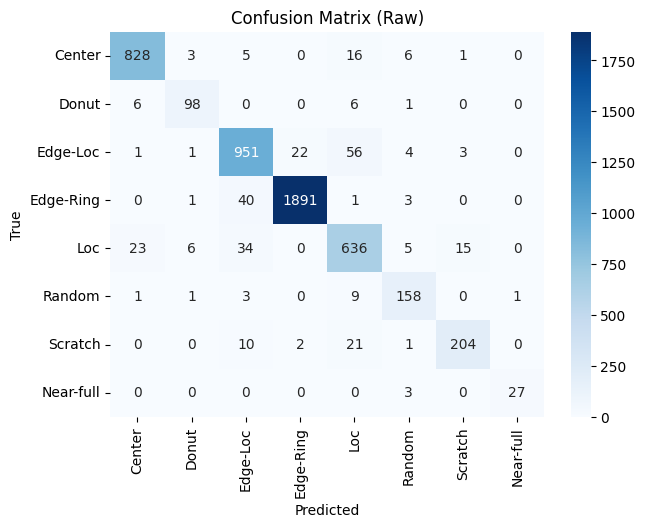

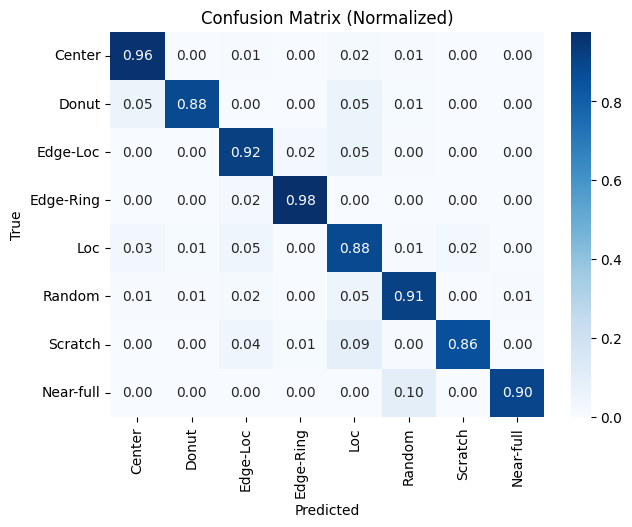

🔹 Confusion Matrix (Raw) 배열:
[[ 828,    3,    5,    0,   16,    6,    1,    0],
 [   6,   98,    0,    0,    6,    1,    0,    0],
 [   1,    1,  951,   22,   56,    4,    3,    0],
 [   0,    1,   40, 1891,    1,    3,    0,    0],
 [  23,    6,   34,    0,  636,    5,   15,    0],
 [   1,    1,    3,    0,    9,  158,    0,    1],
 [   0,    0,   10,    2,   21,    1,  204,    0],
 [   0,    0,    0,    0,    0,    3,    0,   27]]

🔹 Confusion Matrix (Normalized) 배열:
[[9.64e-01, 3.49e-03, 5.82e-03, 0.00e+00, 1.86e-02, 6.98e-03, 1.16e-03,
  0.00e+00],
 [5.41e-02, 8.83e-01, 0.00e+00, 0.00e+00, 5.41e-02, 9.01e-03, 0.00e+00,
  0.00e+00],
 [9.63e-04, 9.63e-04, 9.16e-01, 2.12e-02, 5.39e-02, 3.85e-03, 2.89e-03,
  0.00e+00],
 [0.00e+00, 5.17e-04, 2.07e-02, 9.77e-01, 5.17e-04, 1.55e-03, 0.00e+00,
  0.00e+00],
 [3.20e-02, 8.34e-03, 4.73e-02, 0.00e+00, 8.85e-01, 6.95e-03, 2.09e-02,
  0.00e+00],
 [5.78e-03, 5.78e-03, 1.73e-02, 0.00e+00, 5.20e-02, 9.13e-01, 0.00e+00,
  5.78e-03],
 [0.00e+00, 0.00

In [ ]:
# 9단계. Confusion Matrix 시각화 + 배열 출력 포함

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

# 클래스 이름 정의
class_names = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

# ✅ 1. 원본 행렬 시각화
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ 2. 정규화 행렬 시각화
plt.figure(figsize=(7,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ 3. 배열 형태 출력
print("🔹 Confusion Matrix (Raw) 배열:")
print(np.array2string(cm, separator=', '))

print("\n🔹 Confusion Matrix (Normalized) 배열:")
print(np.array2string(cm_norm, separator=', ', precision=2))
